# Training

In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE
from src.starcattovae.nn.cvae import CVAE

In [5]:
from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import animate_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution
from src.starcattovae.plotting import plot_single_signal

In [6]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [7]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 512

x_length = 256
hidden_dim = 512
latent_dim = 8
num_channels = 1
lr = 1e-3

Using device: mps


## Load Training Data

In [8]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True)
validation_dataset = Data(indices=validation_indices, train=False)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [9]:
train_dataset.summary()
validation_dataset.summary()

2025-05-14 21:32:39.597 | INFO     | src.starcattovae.training.data:summary:118 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)
Parameter Dataset shape: (1515, 1)

2025-05-14 21:32:39.598 | INFO     | src.starcattovae.training.data:summary:118 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)
Parameter Dataset shape: (169, 1)



In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
# Assuming you have a PyTorch DataLoader
for batch in train_dataloader:  # train_dataloader is the DataLoader object
    data_example, param = batch  # Unpack batch
    data_shape = data_example.shape
    condition_dim = param.shape[1] if len(param.shape) > 1 else 1  # Assuming batch first

    print(f"Data shape: {data_shape}")
    print(f"Parameter shape: {param.shape}")
    print(f"Parameter example: {param[0]}")
    break  # Only process the first batch

Data shape: torch.Size([32, 1, 256])
Parameter shape: torch.Size([32, 1, 1])
Parameter example: tensor([[0.1741]])


## Load VAE

In [12]:
model = VAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, input_channels=1, DEVICE=DEVICE).to(DEVICE)
# model_conditional = CVAE(input_dim=x_length, hidden_dim=hidden_dim, latent_dim=latent_dim, condition_dim=condition_dim, DEVICE=DEVICE).to(DEVICE)

### Loss Function

In [13]:
def loss_function(x, x_hat, mean, log_var):
    # sse loss
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    reproduction_loss *= 1 * x.shape[1]
    
    # KL Divergence loss
    kld_loss = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # total loss
    total_loss = reproduction_loss + kld_loss

    return total_loss, reproduction_loss, kld_loss

optimizer = Adam(model.parameters(), lr=lr)

### Train VAE

Start training VAE...


Training:   0%|          | 0/512 [00:00<?, ?it/s]

torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size

Training:   0%|          | 0/512 [00:01<?, ?it/s]

Epoch 1, Train Loss: 204.2327, Val Loss: 133.7785


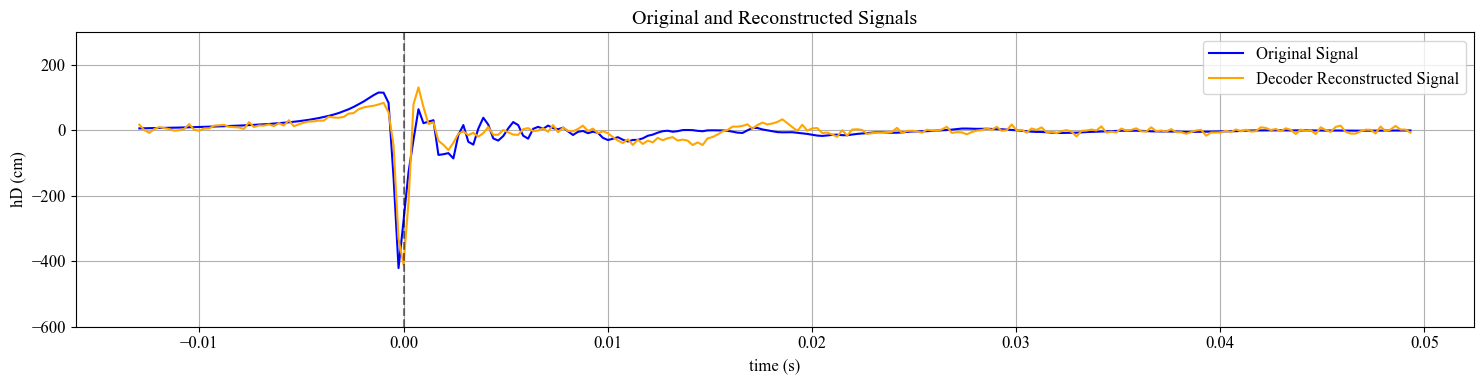

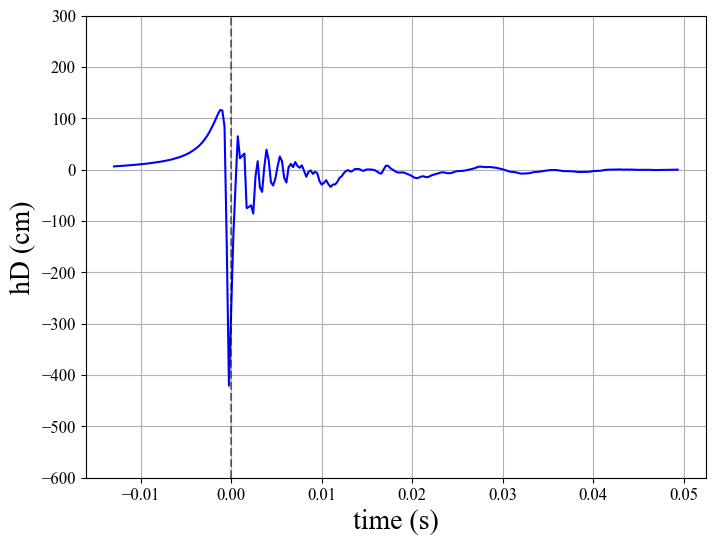

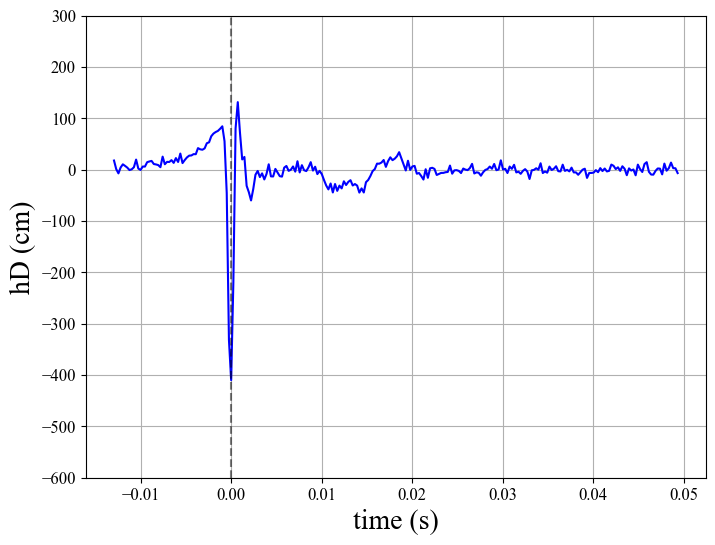

torch.Size([32, 256])


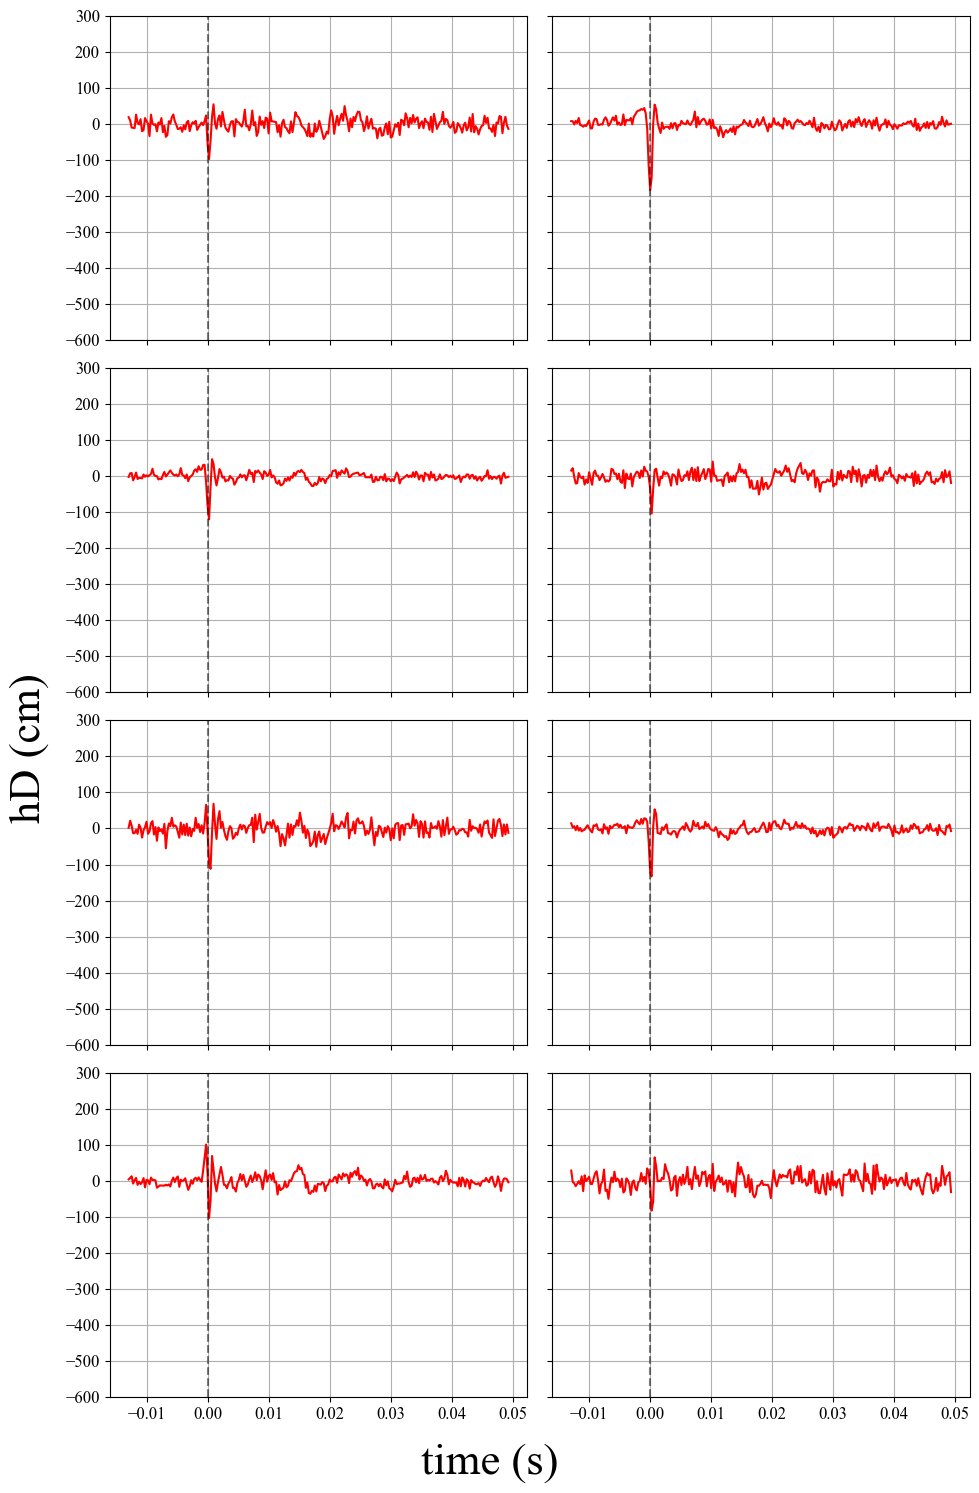

Training:   0%|          | 1/512 [00:01<16:54,  1.99s/it]

torch.Size([256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169

Training:   0%|          | 1/512 [00:02<16:54,  1.99s/it]

torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([11, 256])
torch.Size([169, 256])
Epoch 2, Train Loss: 108.9606, Val Loss: 96.4544


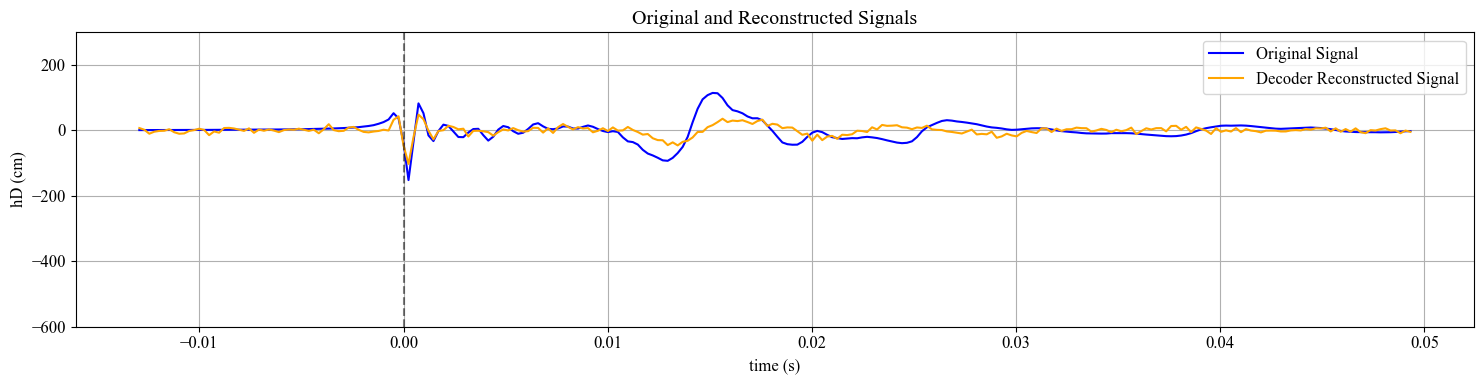

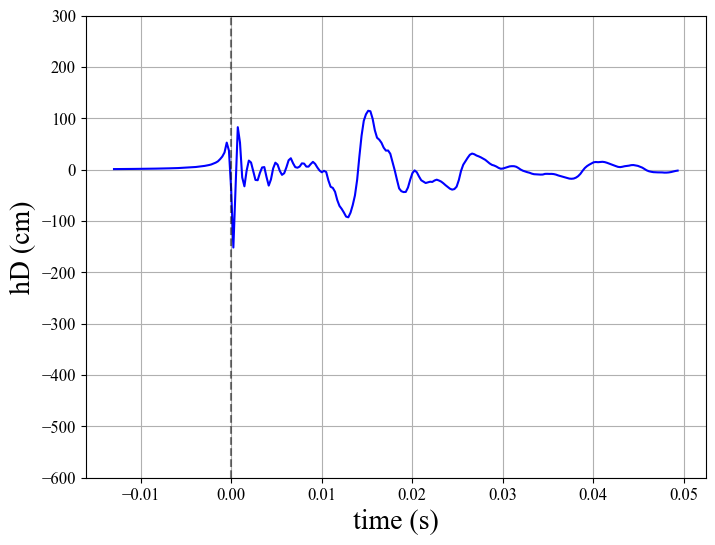

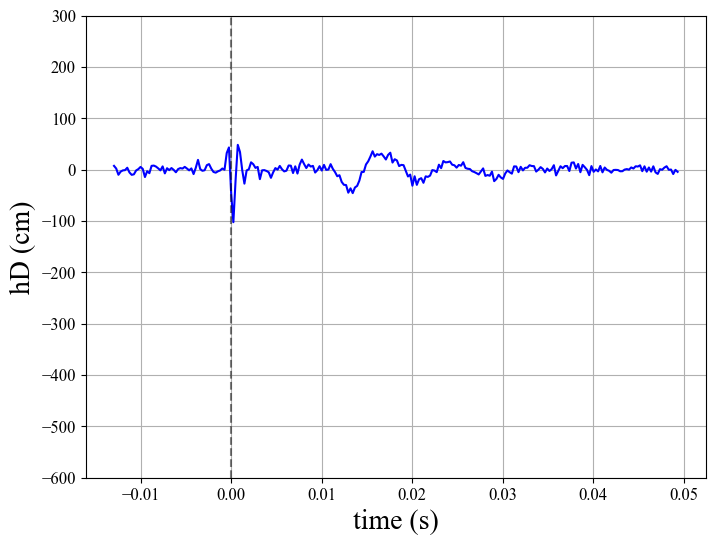

torch.Size([32, 256])


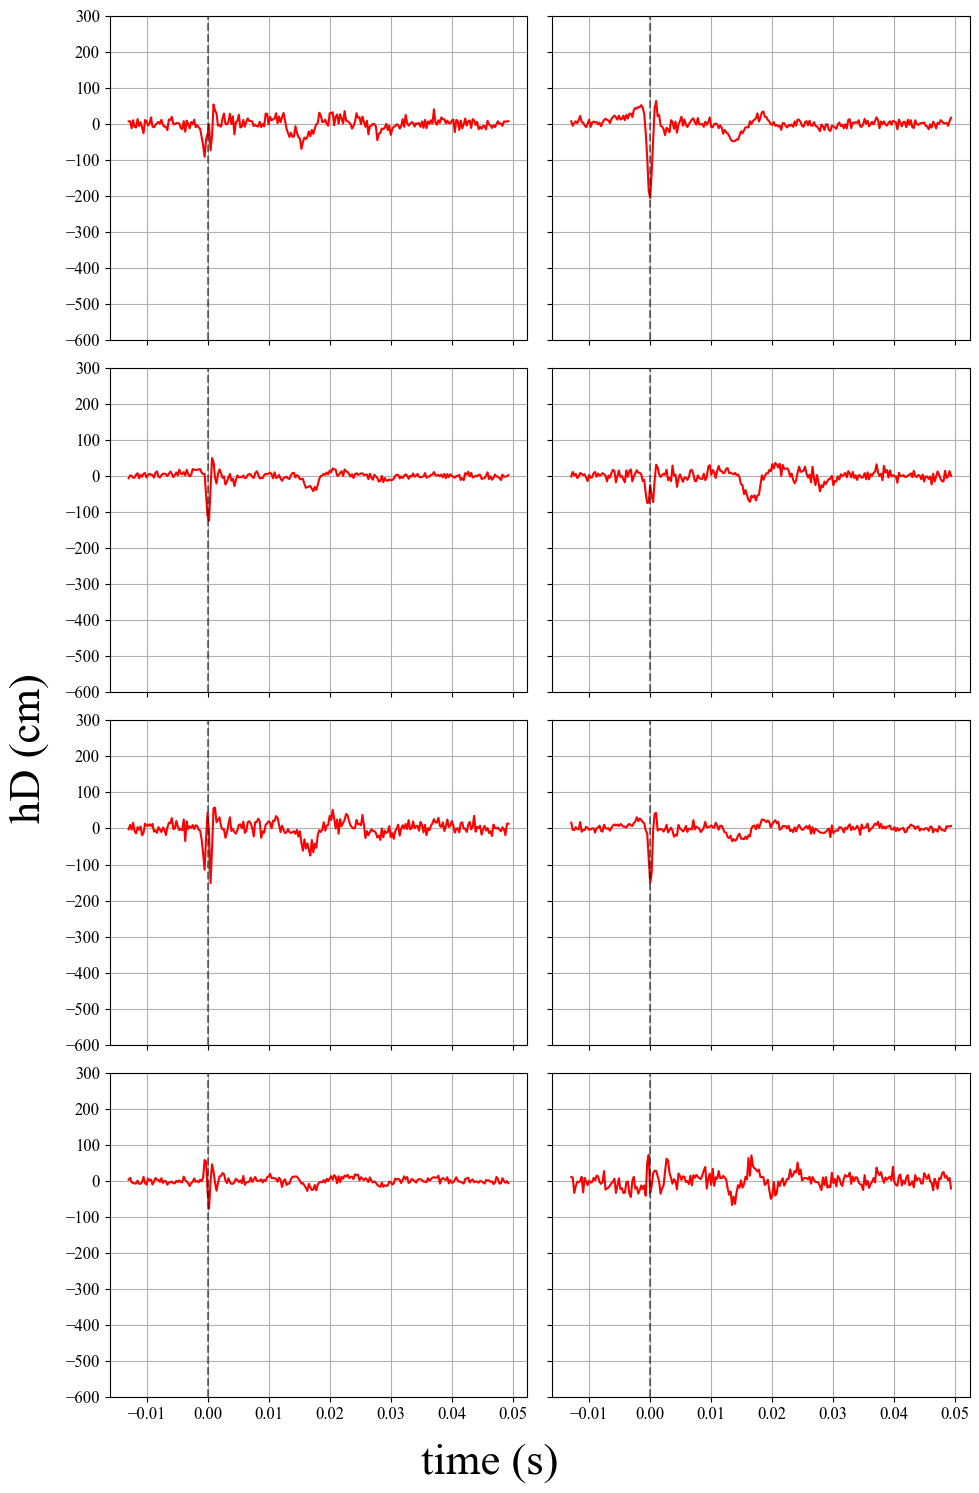

Training:   0%|          | 2/512 [00:03<14:10,  1.67s/it]

torch.Size([256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169

Training:   0%|          | 2/512 [00:04<14:10,  1.67s/it]

torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([11, 256])
torch.Size([169, 256])
Epoch 3, Train Loss: 79.8251, Val Loss: 70.9613


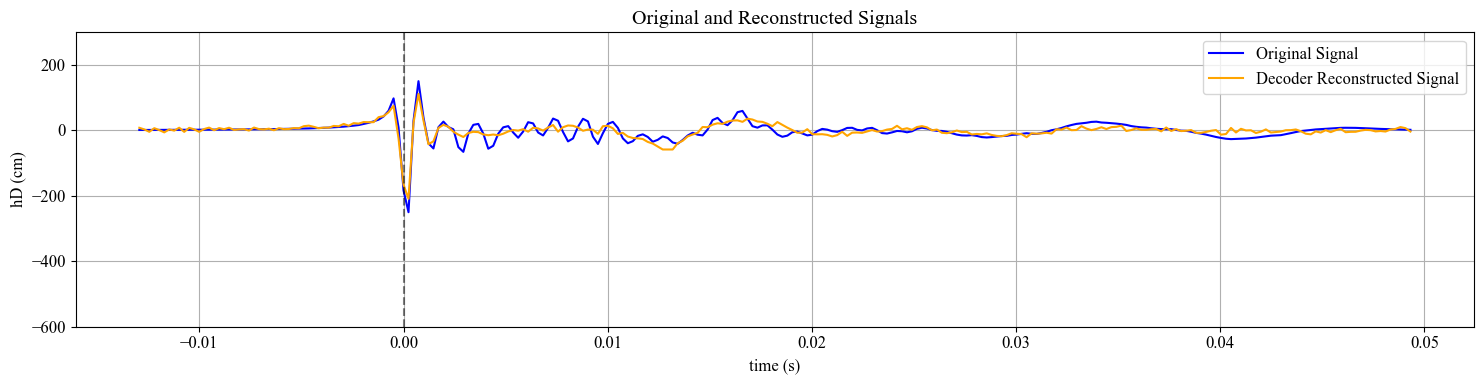

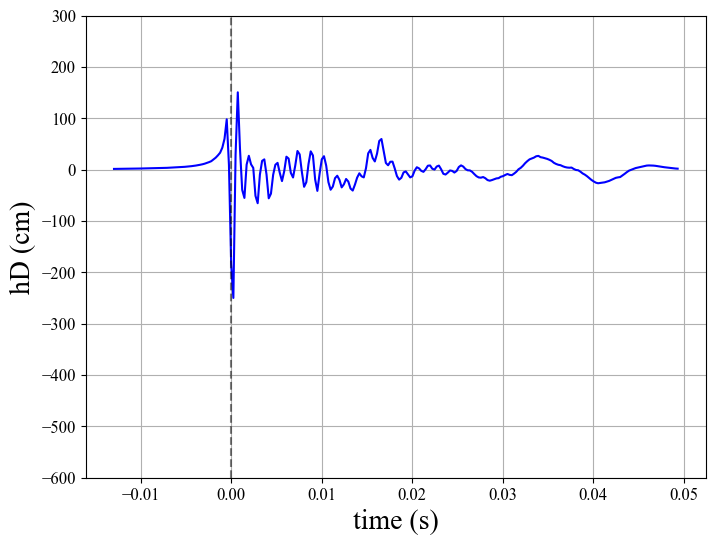

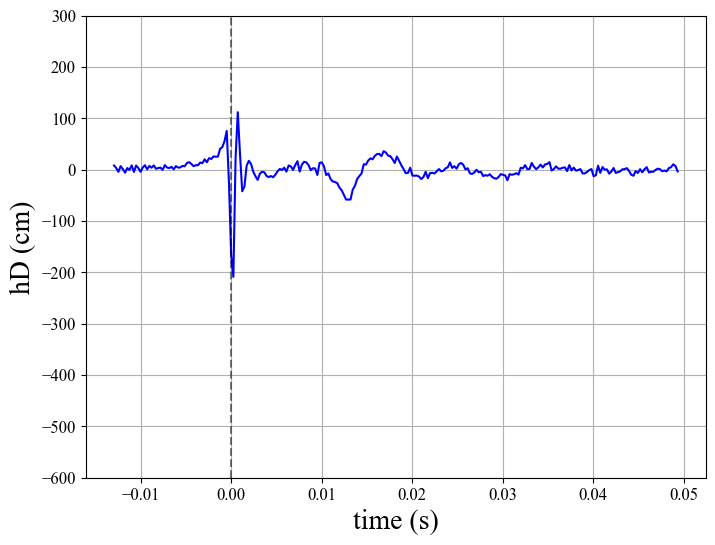

torch.Size([32, 256])


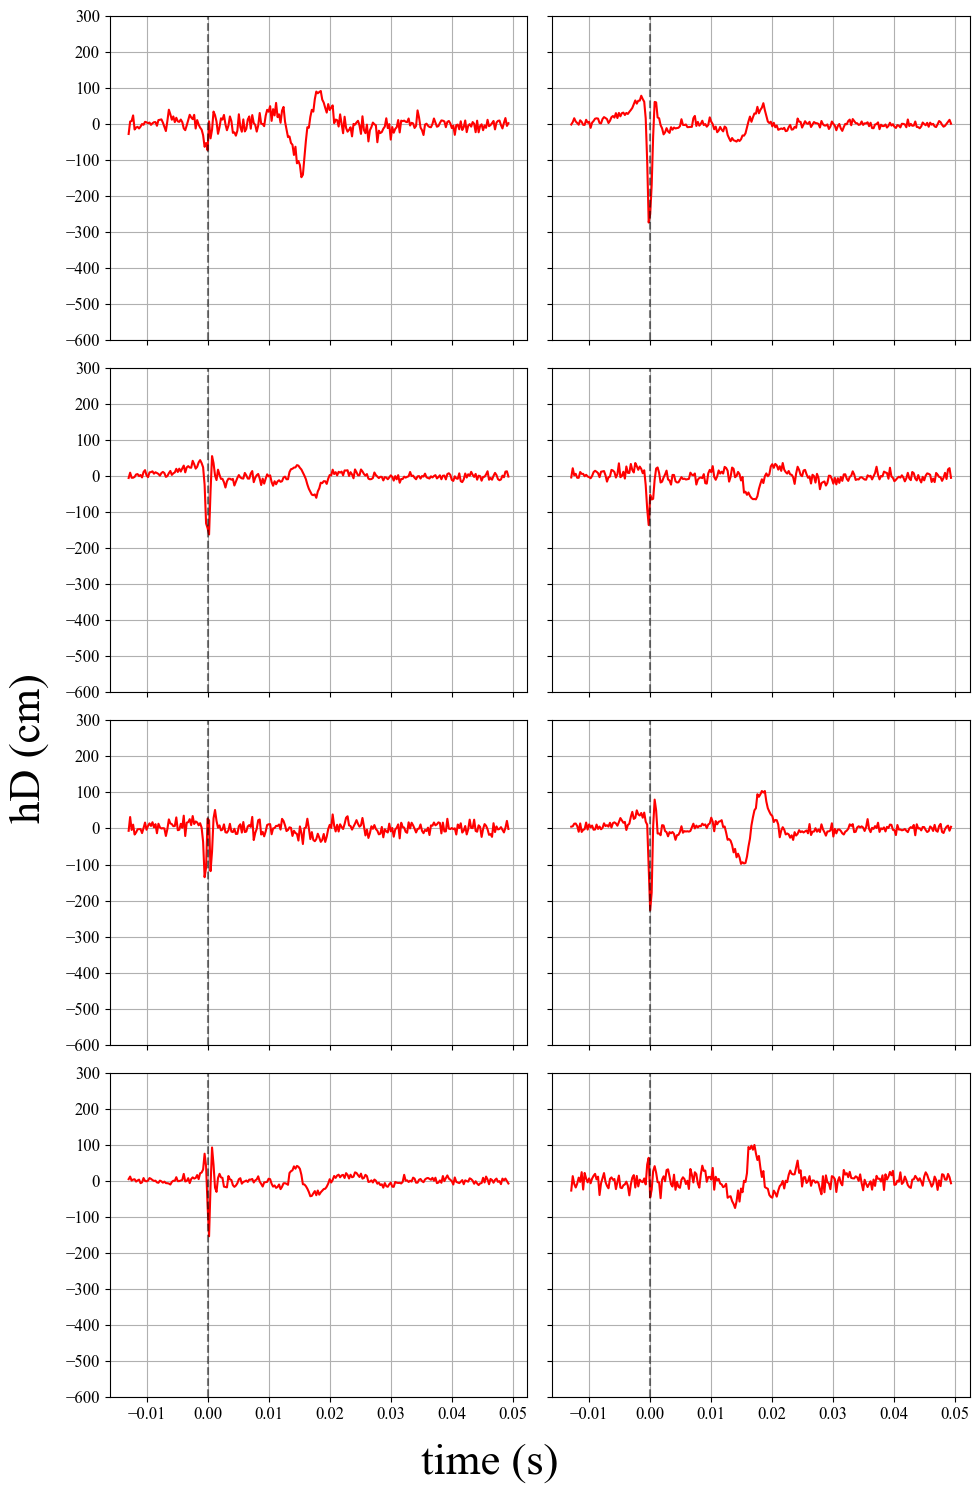

Training:   1%|          | 3/512 [00:04<13:27,  1.59s/it]

torch.Size([256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169

Training:   1%|          | 3/512 [00:05<13:27,  1.59s/it]

torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([11, 256])
torch.Size([169, 256])
Epoch 4, Train Loss: 64.0718, Val Loss: 62.7373


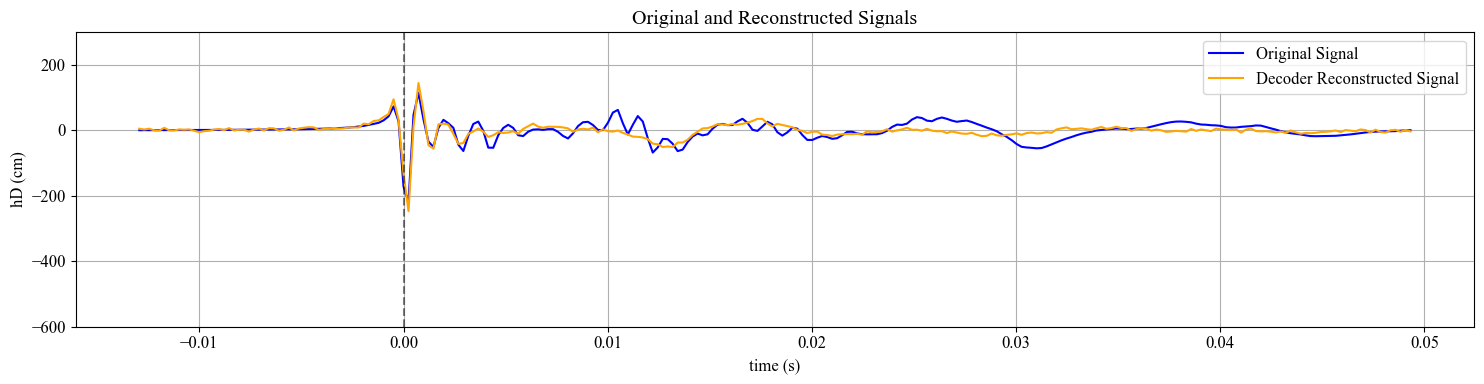

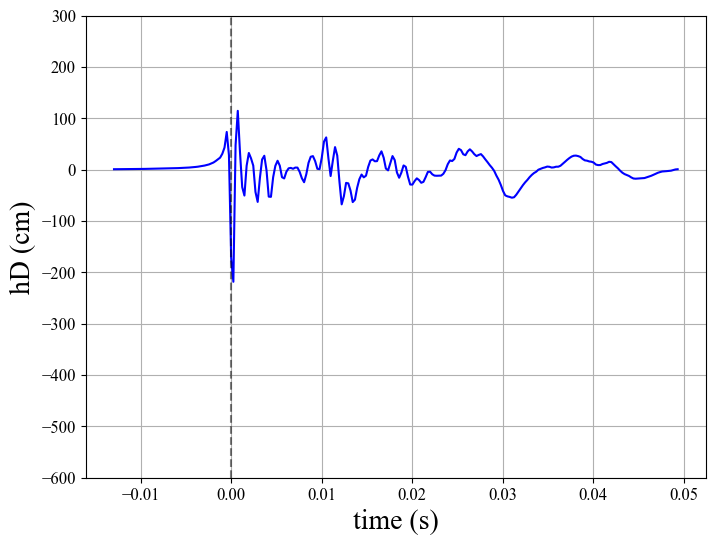

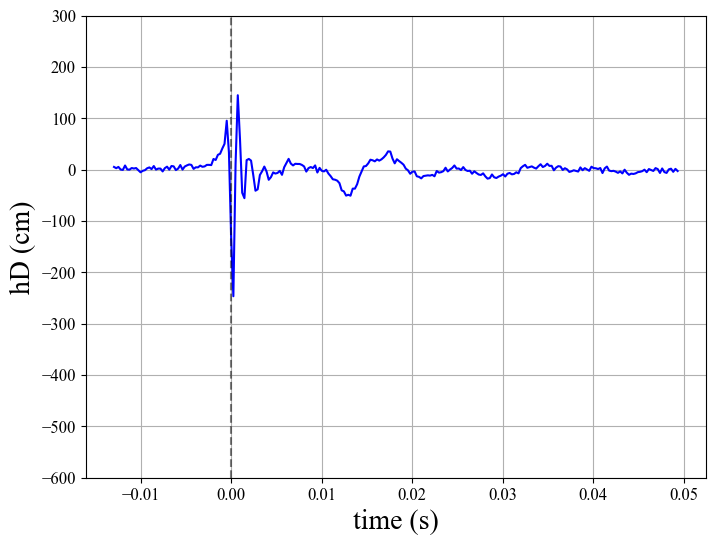

torch.Size([32, 256])


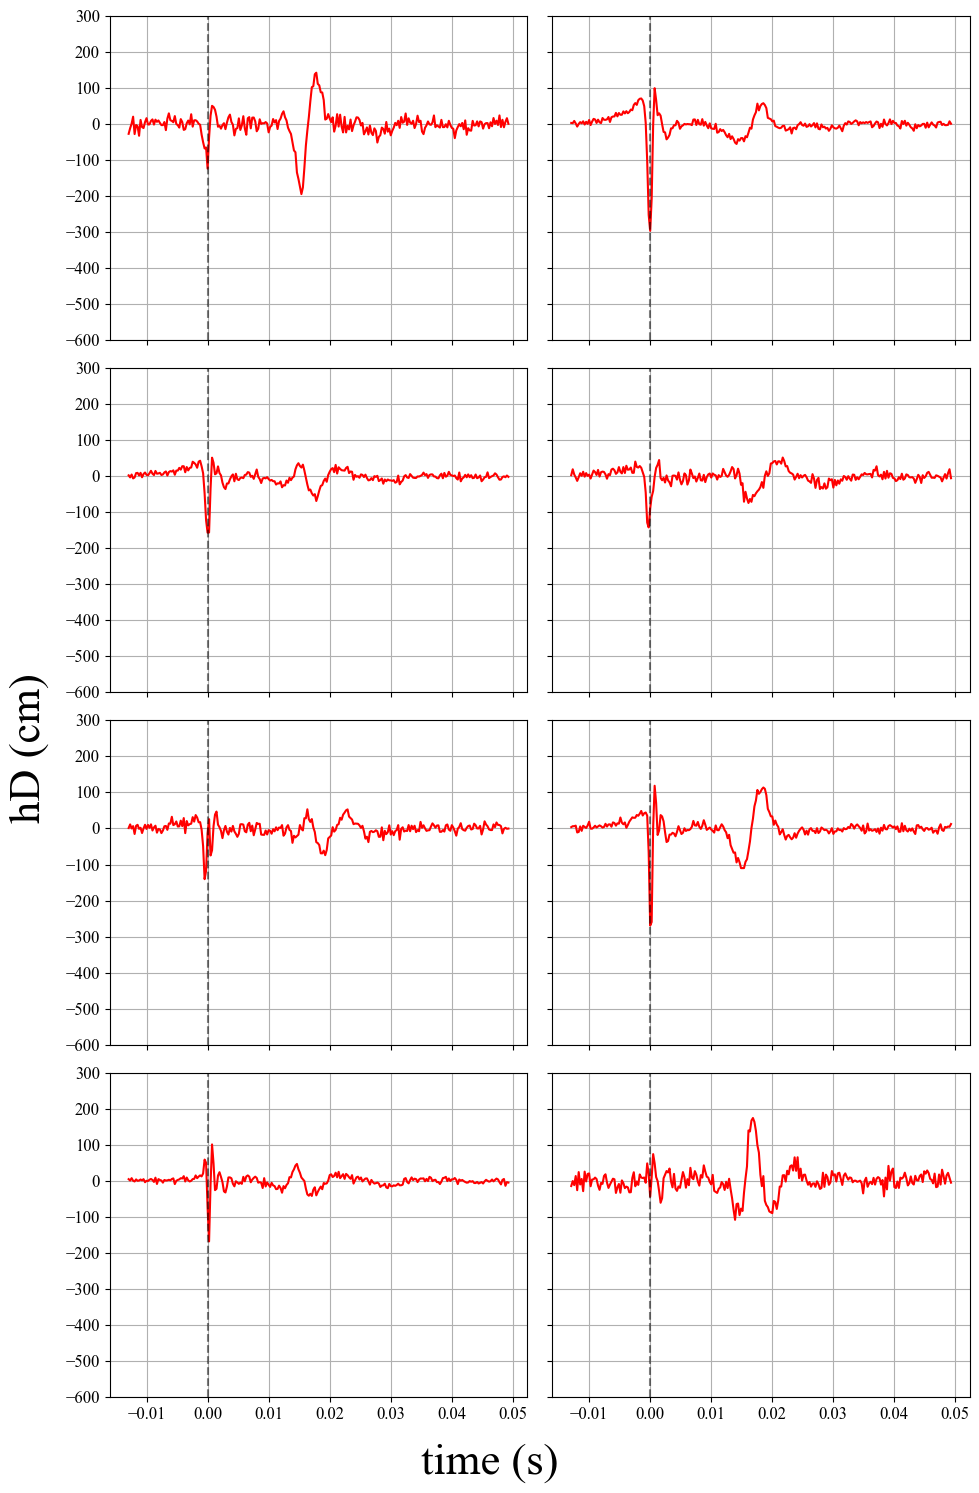

Training:   1%|          | 4/512 [00:06<12:54,  1.52s/it]

torch.Size([256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169

Training:   1%|          | 4/512 [00:07<12:54,  1.52s/it]

torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([11, 256])
torch.Size([169, 256])
Epoch 5, Train Loss: 57.2316, Val Loss: 58.3454


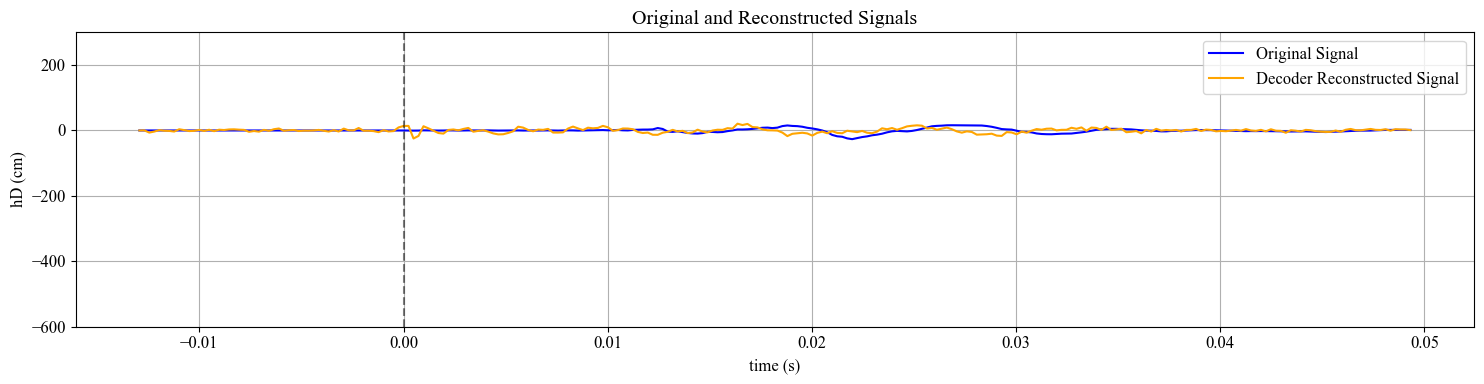

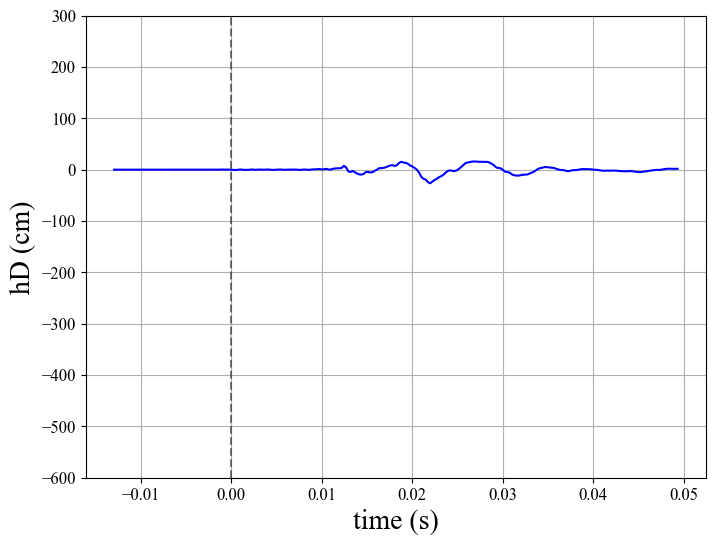

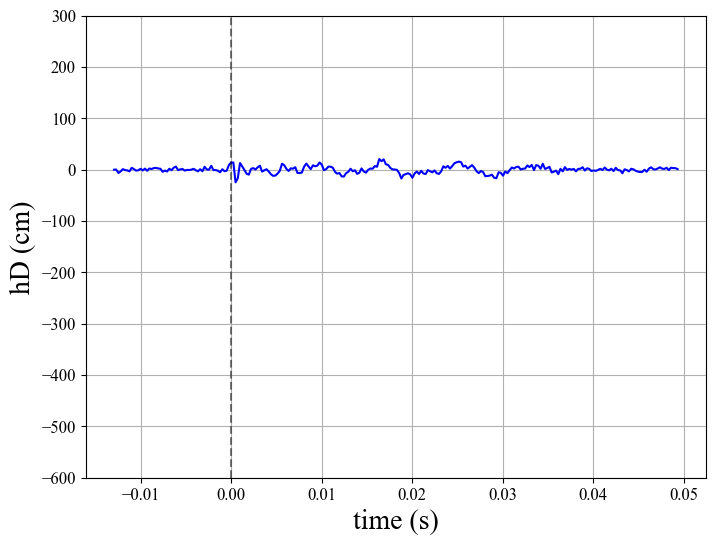

torch.Size([32, 256])


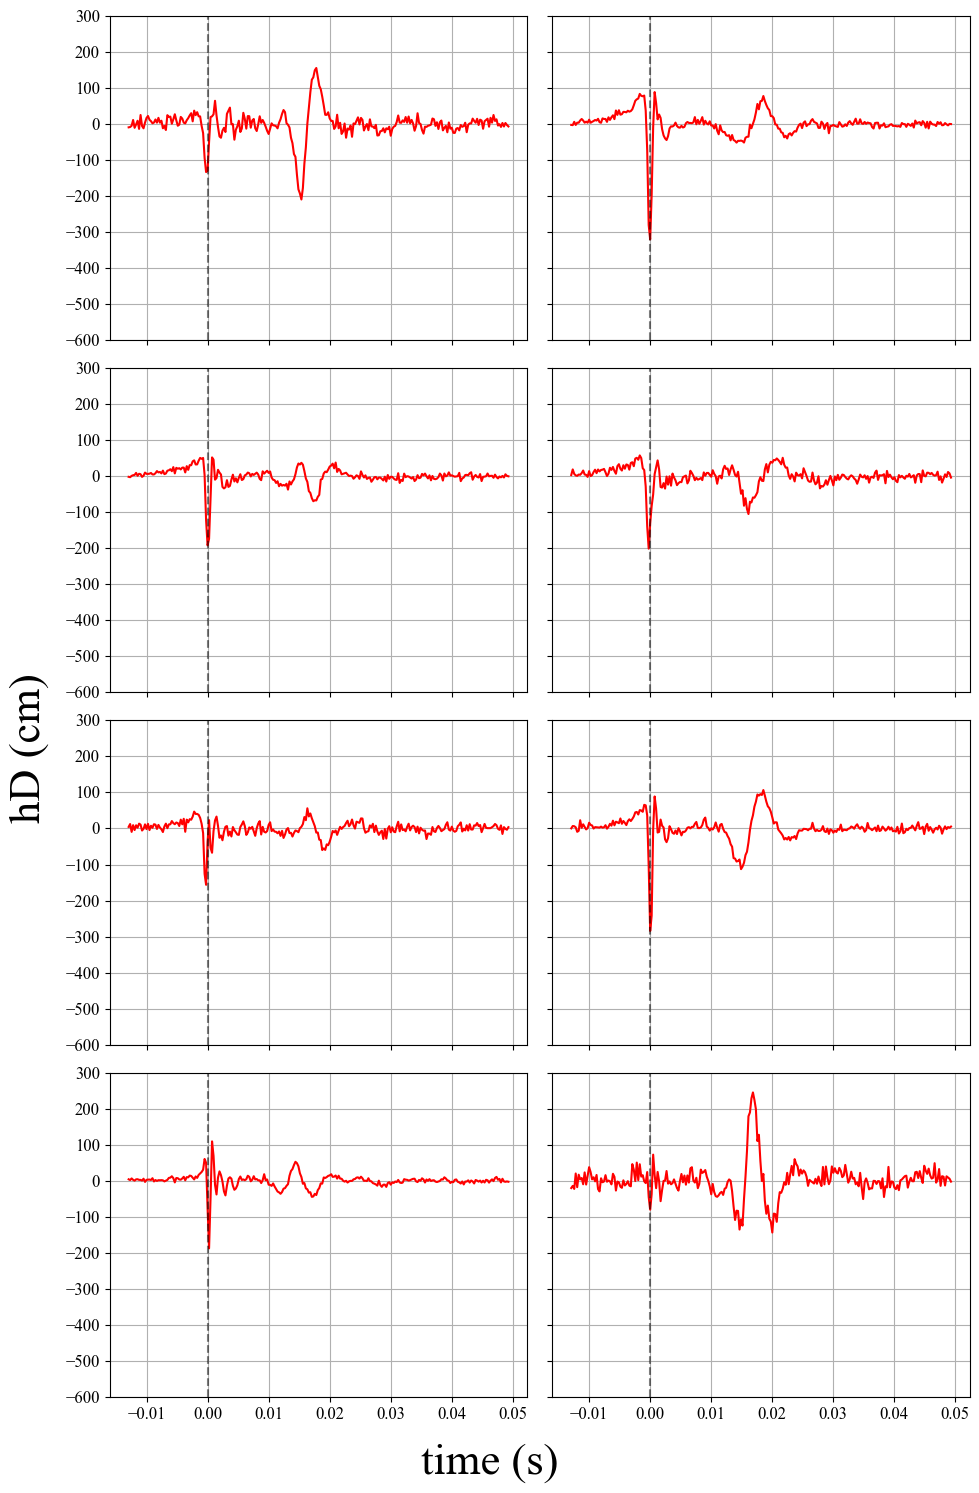

Training:   1%|          | 5/512 [00:07<12:50,  1.52s/it]

torch.Size([256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169

Training:   1%|          | 5/512 [00:08<12:50,  1.52s/it]

torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([11, 256])
torch.Size([169, 256])
Epoch 6, Train Loss: 53.5420, Val Loss: 56.8505


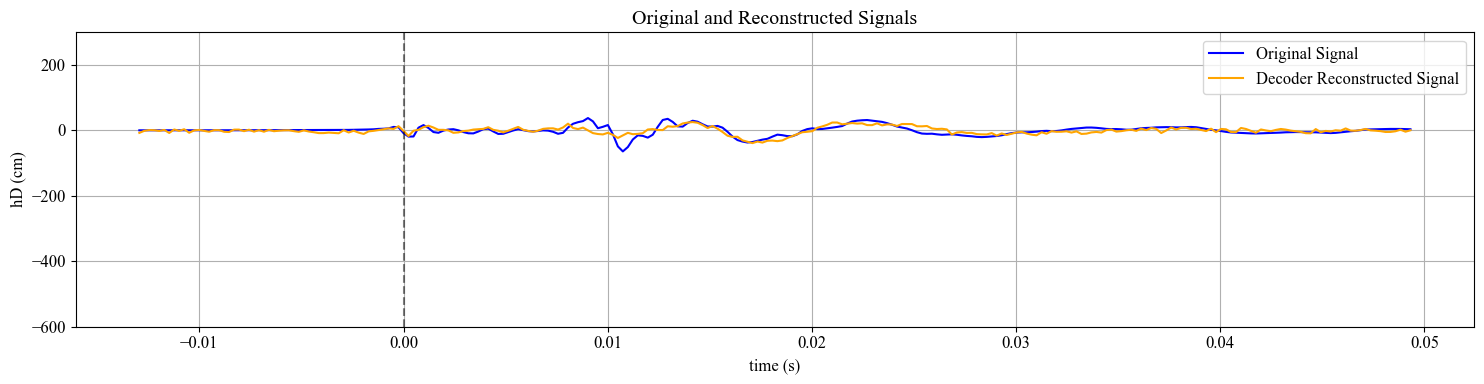

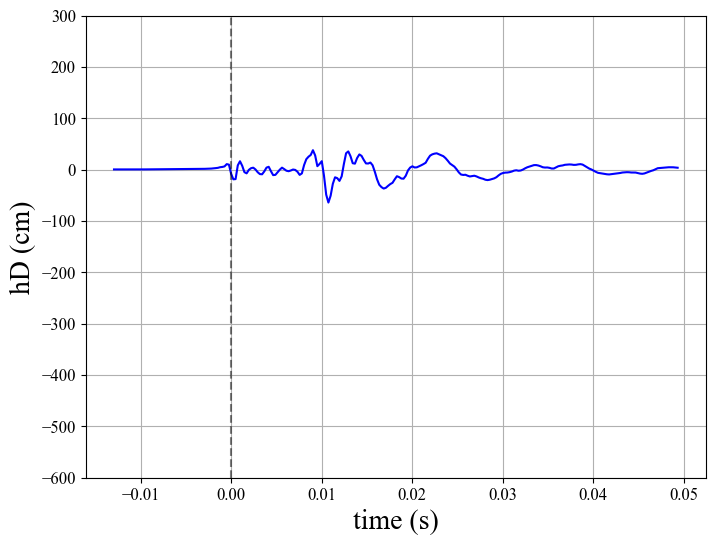

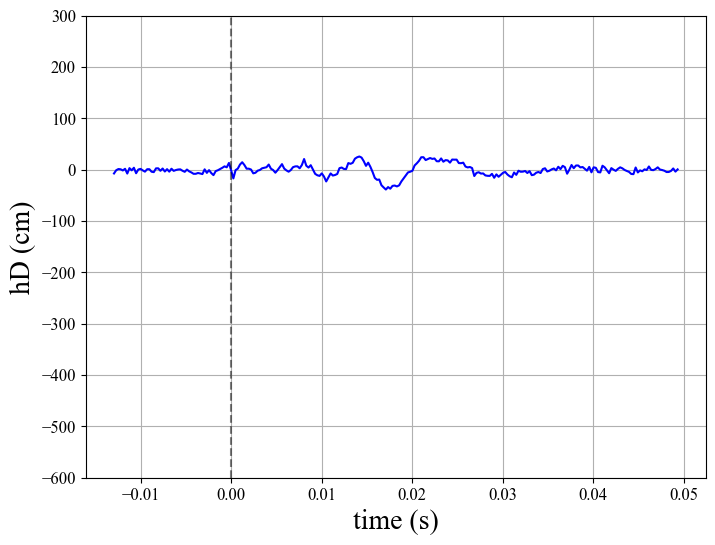

torch.Size([32, 256])


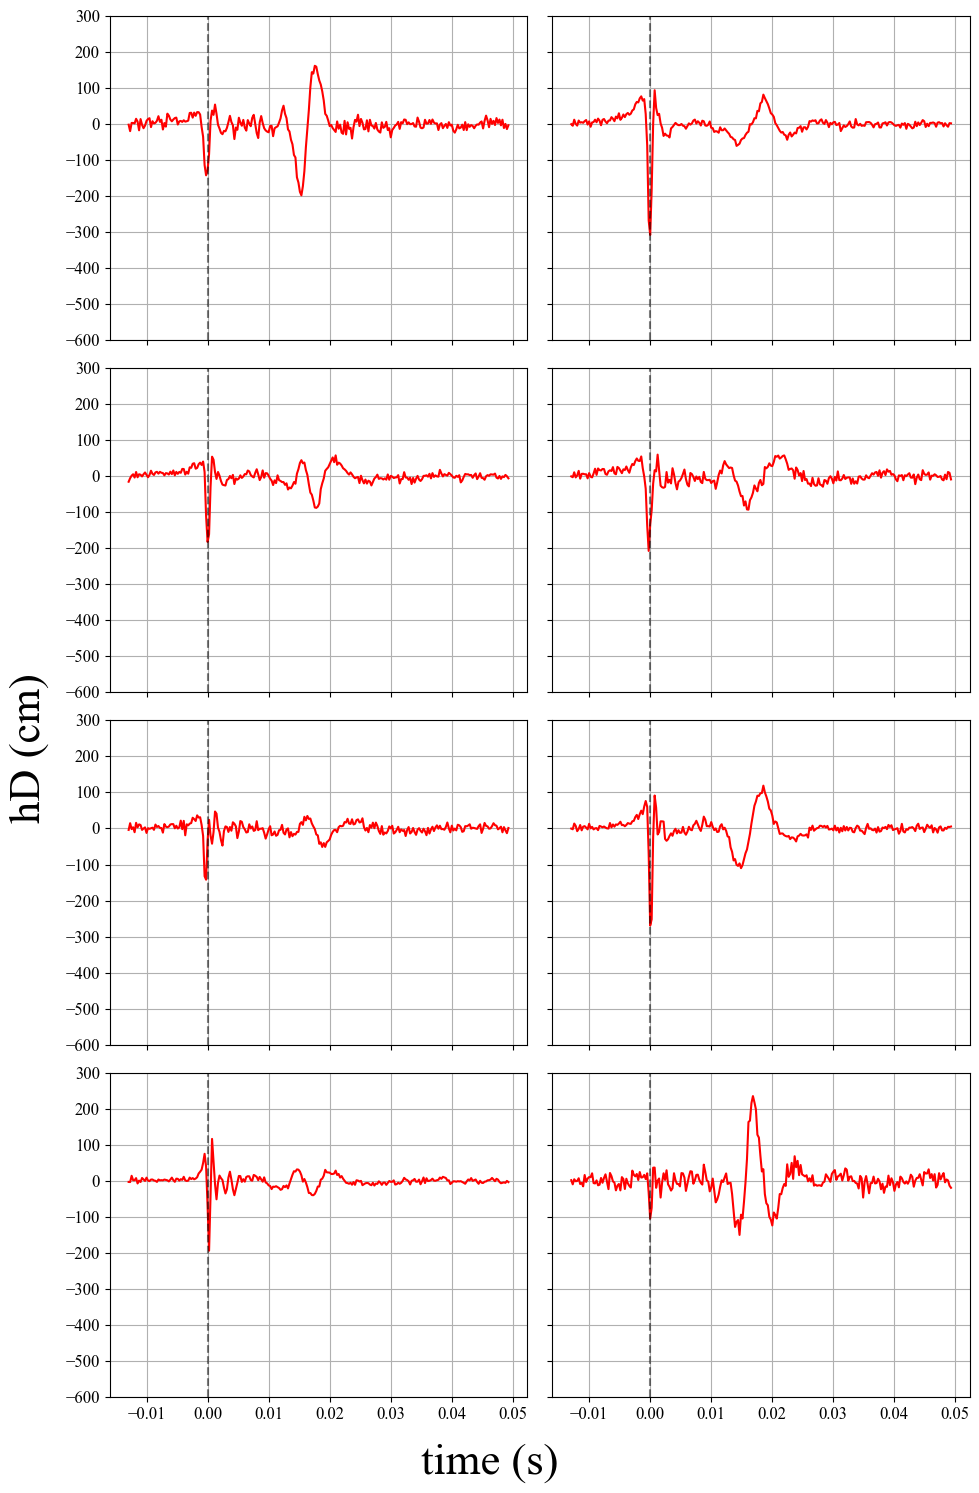

Training:   1%|          | 6/512 [00:09<12:41,  1.50s/it]

torch.Size([256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169

Training:   1%|          | 6/512 [00:10<12:41,  1.50s/it]

torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([32, 256])
torch.Size([169, 256])
torch.Size([11, 256])
torch.Size([169, 256])
Epoch 7, Train Loss: 50.4757, Val Loss: 53.1166


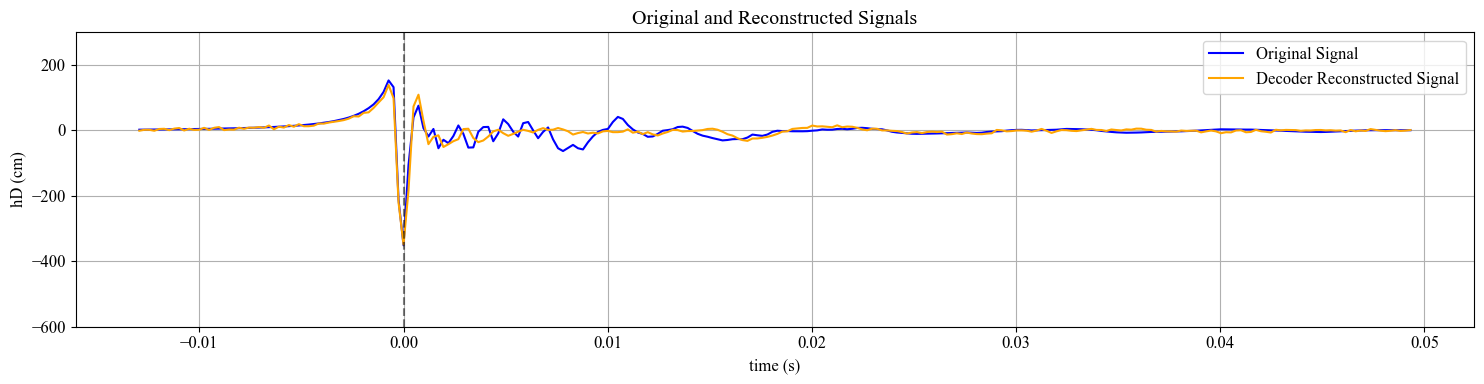

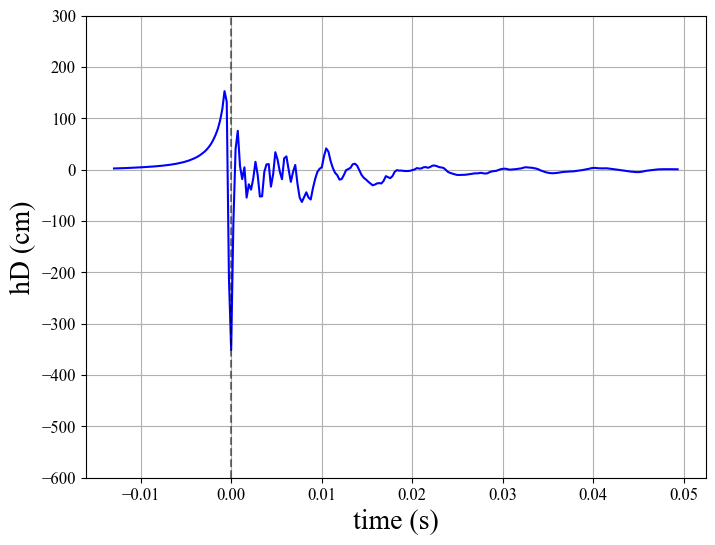

Training:   1%|          | 6/512 [00:10<14:34,  1.73s/it]


KeyboardInterrupt: 

In [14]:
print("Start training VAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []

noise = torch.randn(batch_size, latent_dim).to(DEVICE)

# validation data for validation
validation_data = []
for x_validation, y_validation in validation_dataloader:
    validation_data.append(x_validation.to(DEVICE))
validation_data = torch.cat(validation_data, dim=0)

for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (x, y) in enumerate(train_dataloader, 0):
        model.train()
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        total_loss, reproduction_loss, KLD = loss_function(x, x_hat, mean, log_var)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += reproduction_loss.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        model.eval()
        with torch.no_grad():
            x_validation = validation_data
            x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            x_hat_validation, mean_validation, log_var_validation = model(x_validation)
            total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    avg_kld_loss = overall_kld_loss / total_samples

    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    avg_total_losses_validation.append(avg_total_loss_validation)
    avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    avg_kld_losses_validation.append(avg_kld_loss_validation)

    tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 1 == 0:
        x = x.cpu().detach()
        x_hat = x_hat.cpu().detach()
        plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)
        plot_single_signal(x[0], max_value=train_dataset.max_value)
        plot_single_signal(x_hat[0], max_value=train_dataset.max_value)

        with torch.no_grad():
            generated_signals = model.decoder(noise).cpu().detach().numpy()
        
        plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

        idx1 = torch.randint(0, x.size(0), (1,)).item()
        idx2 = idx1

        while idx2 == idx1: # ensures we don't sample the same signal
            idx2 = torch.randint(0, x.size(0), (1,)).item()

        signal_1 = x[idx1].to(DEVICE)
        signal_2 = x[idx2].to(DEVICE)
        print(signal_1.shape)
        # plot_latent_morphs(model, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)
        # filename = f"gifs/latent_morph_animation_epoch_{epoch+1}.gif"
        # animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path=filename)        

print("Training finished!")
model.eval()

### Training and Validation Loss

In [ ]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

In [ ]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Generated XXXXX Signals

In [ ]:
number_of_signals = 10000
noise = torch.randn(number_of_signals, latent_dim).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    generated_signals = model.decoder(noise).cpu().detach().numpy()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

In [ ]:
generated_signals_transpose = np.empty((x_length, 0))

for i in range(number_of_signals):
    y = generated_signals[i, :].flatten()
    y = y * train_dataset.max_value
    y = y.reshape(-1, 1)
    
    generated_signals_transpose = np.concatenate((generated_signals_transpose, y), axis=1)

# save_path = "../generated_signals.csv"
np.savetxt(save_path, generated_signals_transpose, delimiter=",")

### Plot Generated Distribution

In [ ]:
plot_signal_distribution(generated_signals_transpose, generated=True)

### Morph Animation

In [ ]:
# select signals here

# plot and save animations
signal_1 = x[0].to(DEVICE)
signal_2 = x[7].to(DEVICE)
# animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="latent_morph_animation_3.gif")